# Non-Private Centralized Logistic Regression

In [1]:
# add files that we need!
import os
import sys
import logging 
logger = logging.getLogger()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src.model.logistic_regression_models import MeanFieldMultiDimensionalLogisticRegression
from src.privacy_accounting.optimizer.standard_optimizer import StandardOptimizer

import torch
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

# plotting
%matplotlib inline

In [21]:
prior_params = {
    "w_nat_mean": np.array([0.0, 0.0], dtype=np.float64),
    "w_pres": np.array([0.1, 0.1], dtype=np.float64) 
}

# initally local likelihood is zero - init at the prior!
current_params = prior_params 

hyperparameters = {
    "n_in": 2,
    "N_samples": 50,
    "N_steps": 500,
    "base_optimizer_class": optim.SGD,
    "base_optimizer_parameters": {'lr': 0.02},
    "wrapped_optimizer_class": StandardOptimizer,
    "wrapped_optimizer_parameters": {},
}

logRegressionModel = MeanFieldMultiDimensionalLogisticRegression(current_params, hyperparameters)

In [22]:
data_x = np.array([[2, 2], [1, 1], [0, 1], [1, 0], [-0.5, 0.1], 
                       [-1, -1], [-2, -2], [0, -1], [-1, 0],
                       [0.5, 0.1]], dtype=np.float64)
data_y = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1, -1], dtype=np.float64)

def plot_results(data_x, data_y, opt_params):
    x_vals = data_x[:, 0]
    y_vals = data_x[:, 1]
    labels = data_y
    plt.figure()
    plt.grid(b=True)
    plt.scatter(x_vals, y_vals, c = labels)

    w_map = opt_params['w_nat_mean']/opt_params['w_pres']
    plt.arrow(0, 0, w_map[0], w_map[1], head_width=0.1)
    plt.plot([-2, 2], [(w_map[0]/w_map[1])*2, (w_map[0]/w_map[1])*-2])
    plt.show()
    
def plot_training(training_array):
    x_vals = np.arange(1, training_array.size+1)
    plt.figure()
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()
    
data = {
    "X": data_x,
    "y": data_y,
}

t = {
    "w_nat_mean": np.array([0, 0]),
    "w_pres": np.array([0, 0]) 
}


In [23]:
opt_params, training_curve = logRegressionModel.fit(data, t, prior_params, hyperparameters)

Loss: 18.001
Loss: 6.905
Loss: 5.617
Loss: 5.001
Loss: 5.133
Loss: 4.562
Loss: 4.665
Loss: 4.876
Loss: 4.925
Loss: 4.711
Loss: 4.884
Loss: 4.897
Loss: 4.727
Loss: 4.796
Loss: 4.658
Loss: 4.535
Loss: 4.648
Loss: 4.498
Loss: 4.821
Loss: 4.659


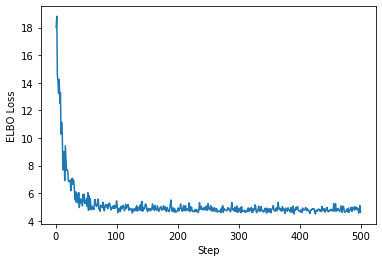

In [24]:
plot_training(training_curve)

{'w_nat_mean': array([0.82413353, 1.29723028]), 'w_pres': array([0.69043349, 0.40866072])}


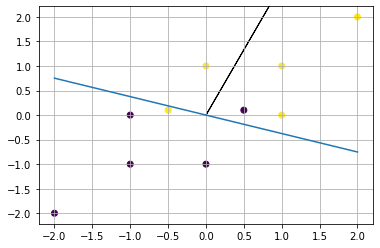

In [28]:
print(opt_params)
plot_results(data_x, data_y, opt_params)

# Let's use DP-SGD Instead!

In [50]:
from src.privacy_accounting.optimizer.dp_optimizer import DPGaussianOptimizer
from src.privacy_accounting.analysis import PrivacyLedger

ledger = PrivacyLedger(data_x.shape[0], 1)

hyperparameters = {
    "n_in": 2,
    "N_samples": 100,
    "N_steps": 1000,
    "base_optimizer_class": optim.SGD,
    "base_optimizer_parameters": {'lr': 0.01},
    "wrapped_optimizer_class": DPGaussianOptimizer,
    "wrapped_optimizer_parameters": {
                                     'l2_norm_clip':5.0,
                                     'noise_multiplier': 1,
                                     'num_microbatches': None,
                                     'ledger': ledger,
                                    }
}

logRegressionModel = MeanFieldMultiDimensionalLogisticRegression(current_params, hyperparameters)

Loss: 17.752
Loss: 7.700
Loss: 5.926
Loss: 4.857
Loss: 5.071
Loss: 5.075
Loss: 4.971
Loss: 5.102
Loss: 5.226
Loss: 5.152
Loss: 4.824
Loss: 4.967
Loss: 5.323
Loss: 5.193
Loss: 4.687
Loss: 4.960
Loss: 5.329
Loss: 4.899
Loss: 4.726
Loss: 4.845


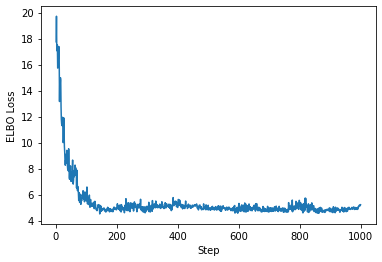

In [51]:
opt_params, training_curve = logRegressionModel.fit(data, t, prior_params, hyperparameters)
plot_training(training_curve)

{'w_nat_mean': array([1.11710618, 3.56638721]), 'w_pres': array([0.7611195 , 0.94981051])}


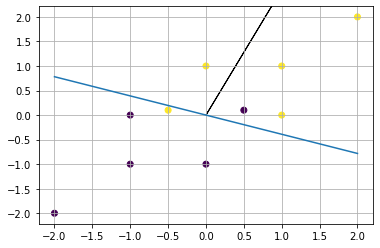

In [52]:
print(opt_params)
plot_results(data_x, data_y, opt_params)